https://www.kaggle.com/jerifate/fake-news-basic-work-tensorflow-with-bert/notebook#1.-Import-&-Install-libray
#Import & Install libray

In [ ]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau



from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/c0pper/fakenews_detector/main/Tutorials/Fake%20News%20Basic%20work%20Tensorflow%20with%20Bert/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/c0pper/fakenews_detector/main/Tutorials/Fake%20News%20Basic%20work%20Tensorflow%20with%20Bert/test.csv')
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#Inspecting data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
train_df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [ ]:
print("[title]",train_df['title'][0])
print("[author]",train_df['author'][0])
print("[text]",train_df['text'][0])

[title] House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
[author] Darrell Lucus
[text] House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democra

#Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]


*   Label Percent
*   Text length / Word length per Label Percent



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


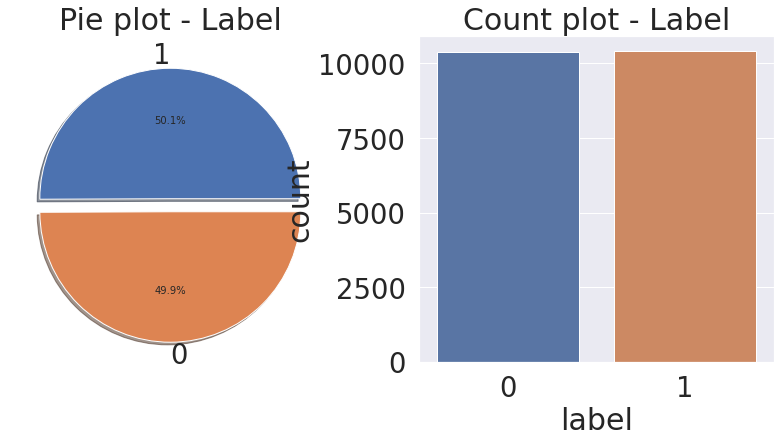

In [ ]:
f,ax = plt.subplots(1,2,figsize=(14,6))
train_df['label'].value_counts().plot.pie(explode=[0, 0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Label')
ax[0].set_ylabel('')
sns.countplot('label', data = train_df, ax=ax[1])
ax[1].set_title('Count plot - Label')
plt.show()

In [ ]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [ ]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [ ]:
train_df['length_alphabets'] = train_df['text'].apply(get_length_alphabets)
train_df['length_words'] = train_df['text'].apply(get_length_words)
train_df.head()

,id,title,author,text,label,length_alphabets,length_words
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,820
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,727
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,1266
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,559
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,154


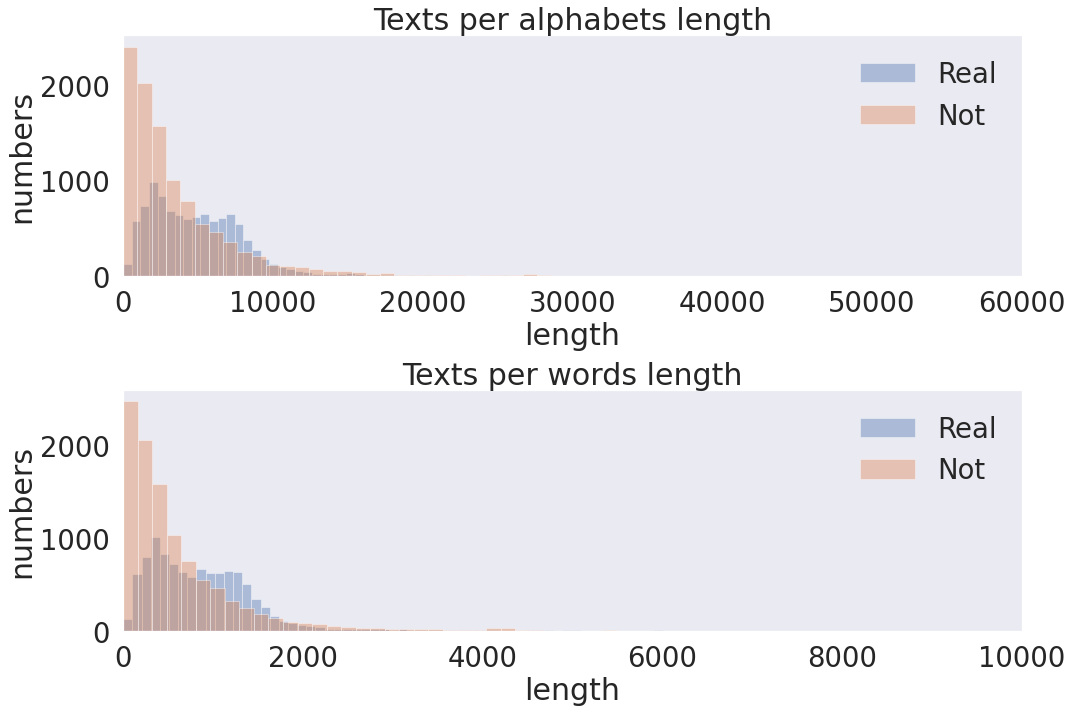

In [ ]:
f, ax = plt.subplots(2,1,figsize=(15,10))

ax[0].set_title('Texts per alphabets length')
ax[0].hist(train_df[train_df['label'] == 0]['length_alphabets'], alpha = 0.4, bins=150, label = 'Real')
ax[0].hist(train_df[train_df['label'] == 1]['length_alphabets'], alpha = 0.4, bins=150, label = 'Not')
ax[0].set_xlabel('length')
ax[0].set_ylabel('numbers')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,60000)
ax[0].grid()

ax[1].set_title('Texts per words length')
ax[1].hist(train_df[train_df['label'] == 0]['length_words'], alpha = 0.4, bins=150, label = 'Real')
ax[1].hist(train_df[train_df['label'] == 1]['length_words'], alpha = 0.4, bins=150, label = 'Not')
ax[1].set_xlabel('length')
ax[1].set_ylabel('numbers')
ax[1].legend(loc='upper right')
ax[1].set_xlim(0,10000)
ax[1].grid()

f.tight_layout()
plt.show()

# Preprocessing Data
* Null value processing
* Drop columns

In [ ]:
train_df[train_df['text'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,3,1
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1,3,1
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1,3,1
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1,3,1
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1,3,1


In [ ]:
train_df['text'].fillna("", inplace=True)
test_df['text'].fillna("", inplace=True)

In [ ]:
train_df[train_df['author'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2729,489
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177,1452
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,2231,377
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,2801,486
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,7050,1146


In [ ]:
train_df['author'] = train_df['author'].fillna('unknown')
test_df['author'] = test_df['author'].fillna('unknown')

In [ ]:
train_df[train_df['title'].isnull()].head()

,id,title,author,text,label,length_alphabets,length_words
53,53,NaN,Dairy✓ᵀᴿᵁᴹᴾ,Sounds like he has our president pegged. What ...,1,679,131
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,135,16
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1,533,100
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,736,120
196,196,NaN,Raffie,They got the heater turned up on high.,1,38,8


In [ ]:
# Get average TRAIN title size
train_df['title_size'] = train_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
train_nan_index = train_df[train_df['title_size']==3].index
train_df['title_size'][train_nan_index] = 0 

train_avg_title_size = int(train_df.value_counts(['title_size']).mean())
print("train avg_title_size: ",train_avg_title_size)

train avg_title_size:  98


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Get average TEST title size
test_df['title_size'] = test_df['title'].apply(lambda x: len(str(x)))

# If title size == 3("NAN") then change title size = 0
test_nan_index = test_df[test_df['title_size']==3].index
test_df['title_size'][test_nan_index] = 0 

test_avg_title_size = int(test_df.value_counts(['title_size']).mean())
print("test avg_title_size: ",test_avg_title_size)

test avg_title_size:  33


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#change title "NAN" to text[:98]
train_df['title'][train_nan_index] = train_df['text'][train_nan_index].apply(lambda x: str(x)[:train_avg_title_size])

test_df['title'][test_nan_index] = test_df['text'][test_nan_index].apply(lambda x: str(x)[:test_avg_title_size])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train_df[train_df['id']==120]

,id,title,author,text,label,length_alphabets,length_words,title_size
120,120,"Same people all the time , i dont know how you...",Anonymous,"Same people all the time , i dont know how you...",1,135,16,0


In [ ]:
train_df.isnull().sum()

id                  0
title               0
author              0
text                0
label               0
length_alphabets    0
length_words        0
title_size          0
dtype: int64

In [ ]:
train_df.drop(['length_alphabets','length_words','title_size'], axis=1, inplace = True)
test_df.drop(['title_size'], axis=1, inplace = True)

In [ ]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,unknown,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


#Feature Engineering


* Concat "author" & "text" Columns
* Normalization
* Plot WordClouds
* Words Tokenization
* Split Train / Test / Validation Data




In [ ]:
train_df['text']= train_df['author'] + " " + train_df['text']
test_df['text']= test_df['author'] + " " + test_df['text']

In [ ]:
train_df.drop(['id','title','author'], axis=1, inplace=True)
test_df.drop(['id','title','author'], axis=1, inplace=True)

In [ ]:
train_df.head()

,text,label
0,Darrell Lucus House Dem Aide: We Didn’t Even S...,1
1,Daniel J. Flynn Ever get the feeling your life...,0
2,Consortiumnews.com Why the Truth Might Get You...,1
3,Jessica Purkiss Videos 15 Civilians Killed In ...,1
4,Howard Portnoy Print \nAn Iranian woman has be...,1


In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

#WordCloud
* Label == 0 Real News
* Label == 1 Fake News

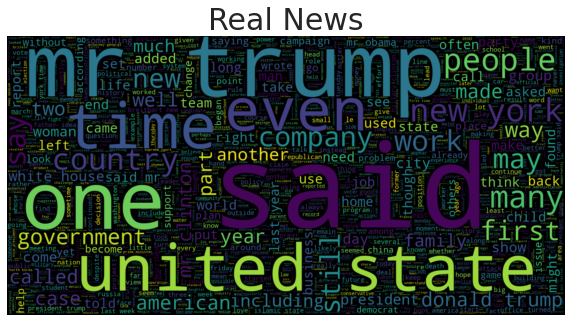

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 0].text))
plt.axis('off')
plt.title('Real News')
plt.imshow(wc,interpolation = 'bilinear')

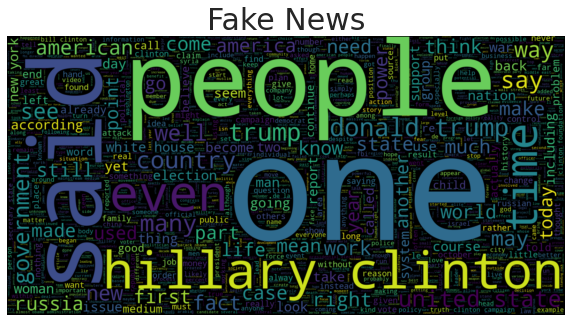

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(train_df[train_df.label == 1].text))
plt.axis('off')
plt.title('Fake News')
plt.imshow(wc,interpolation = 'bilinear')

#Modeling
* LSTM Modeling
* Bert Modeling

In [ ]:
x_train = train_df['text']
y_train = train_df['label']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) #Updates internal vocabulary based on a list of texts.

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  224878


In [ ]:
x_train = pad_sequences(
    tokenizer.texts_to_sequences(x_train),
    maxlen = 256)
x_val = pad_sequences(
    tokenizer.texts_to_sequences(x_val),
    maxlen = 256)
x_test = pad_sequences(
    tokenizer.texts_to_sequences(test_df['text']),
    maxlen = 256)

In [ ]:
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (4160, 256)
y_val shape: (4160,)


In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("First Train data squence info : ", x_train[0].shape)
print(x_train[0])

x_train shape: (16640, 256)
y_train shape: (16640,)
First Train data squence info :  (256,)
[   87   152 49988   508  3375    98  8640   176 11271    36    79  8704
  1333   812    78    34  2034    38  2853   202   246  1540  4596    48
   311  2748 14949   202   214   721  2288  1803   176  2727  2864  1281
   336  8106  1628  5276   610    17  4522    82   521  2477   278   374
   607   508   240   192    80   201    19   619  3916  5277   888 32004
   592   205   704  6710   731  9684  1704  3937    38  8777 10299   607
 14949   240  6900   176    38    17    67  1067  3263  1551  1152   201
    19   619  3916  5277   888 32004   592   205    96   272  1185    82
   278   374  9419   205   206  3073   205  3107   294    79  2161   531
    29   938 13497  4271  4060    38     1   278   374   275   262   508
   415    24   389   341   102 10585 19961  2020   797   124    75     9
    96   144   322  1394   757  2161    21  2864  9591  1061  1603     1
   278   704  6710   731  9684  

In [ ]:
inputs = Input(shape=(256,), dtype='int32')

embedding = tf.keras.layers.Embedding(vocab_size, 300)(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(64,activation = 'relu')(net)
net = Dropout(0.3)(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 300)          67463400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65    

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=512, 
    epochs=3,
    validation_data=(x_val, y_val)
)

Epoch 1/3
33/33 [==============================] - 541s 16s/step - loss: 0.4291 - accuracy: 0.7931 - val_loss: 0.1329 - val_accuracy: 0.9488
Epoch 2/3
33/33 [==============================] - 519s 16s/step - loss: 0.0819 - accuracy: 0.9736 - val_loss: 0.0998 - val_accuracy: 0.9666
Epoch 3/3
33/33 [==============================] - 516s 16s/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.1094 - val_accuracy: 0.9656


In [ ]:
model.save("fakenews_bert")

INFO:tensorflow:Assets written to: fakenews_bert/assets
